# Experimental Variogram

In this notebook, we compute the experimental variogram for a sample area in Greenland to quantify the topographic spatial relationships. Variograms are useful for examining spatial continuity, performing kriging interpolations, and generating stochastic realizations.

We use the SciKit-GStat package for computing variograms. See the documentation (https://scikit-gstat.readthedocs.io/en/latest/) for detailed information on this package.

In [2]:
# load dependencies
import numpy as np
import pandas as pd
import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs

## Load and plot data

Load in bed topography measurements from sample area in Greenland. We use radar bed picks from CReSIS. The coordinates are polar stereographic coordinates with units of meters.

In [3]:
df_bed = pd.read_csv( "LAWUUU.csv", delimiter=";")

df_bed.head()

,X,Y,Bed
0,-7.561067,111.112564,589.4
1,-7.560673,111.117171,653.5
2,-7.559856,111.123300,656.8
3,-7.560173,111.136950,780.1
4,-7.559749,111.152925,757.5


In [4]:
print(f'The data length is {len(df_bed)}')

The data length is 1928


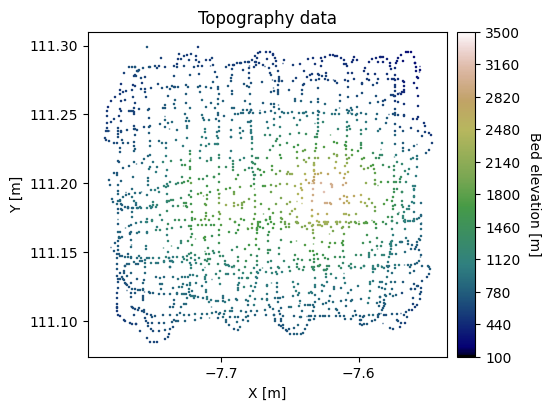

In [16]:
# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(x=df_bed['X'],y=df_bed['Y'], c=df_bed['Bed'], vmin=100, vmax=3500, 
                     marker=',', s=0.5, cmap='gist_earth')
plt.title('Topography data')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(100, 3500, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

In [6]:
print(df_bed.head)
print("Min Bed value:", df_bed['Bed'].min())
print("Max Bed value:", df_bed['Bed'].max())

<bound method NDFrame.head of              X           Y     Bed
0    -7.561067  111.112564   589.4
1    -7.560673  111.117171   653.5
2    -7.559856  111.123300   656.8
3    -7.560173  111.136950   780.1
4    -7.559749  111.152925   757.5
...        ...         ...     ...
1923 -7.669178  111.208850  1650.5
1924 -7.664671  111.224192  1373.5
1925 -7.666407  111.240601  1059.7
1926 -7.668415  111.252030   806.6
1927 -7.664371  111.257954   763.5

[1928 rows x 3 columns]>
Min Bed value: 268.0
Max Bed value: 3179.6


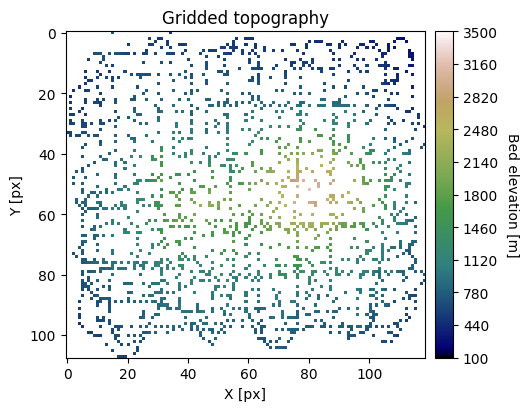

In [15]:
# grid data to 1000 m resolution
res = 0.002
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)

# plot gridded bed
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.imshow(grid_matrix, cmap='gist_earth', vmin=100, vmax=3500, 
                interpolation='none', origin='upper')
plt.title('Gridded topography')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')

# make color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(100, 3500, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

Grid data to the desired simulation resolution. This is important because the resolution of the data affects the spatial statistics. We recommend gridding the data to the resolution at which you will be performing the interpolation.

In [8]:
# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]
df_grid.head()

,X,Y,Sum,Count,Z
17,-7.750886,111.084717,596.6,1.0,596.6
18,-7.748886,111.084717,608.7,1.0,608.7
19,-7.746886,111.084717,585.2,1.0,585.2
141,-7.740886,111.086717,627.9,1.0,627.9
253,-7.754886,111.088717,623.4,1.0,623.4


## Compute normal score transformation

Many geostatistical methods require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical analysis such as kriging, the data is back-transformed to it's original distribution.

In [9]:
# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=75, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

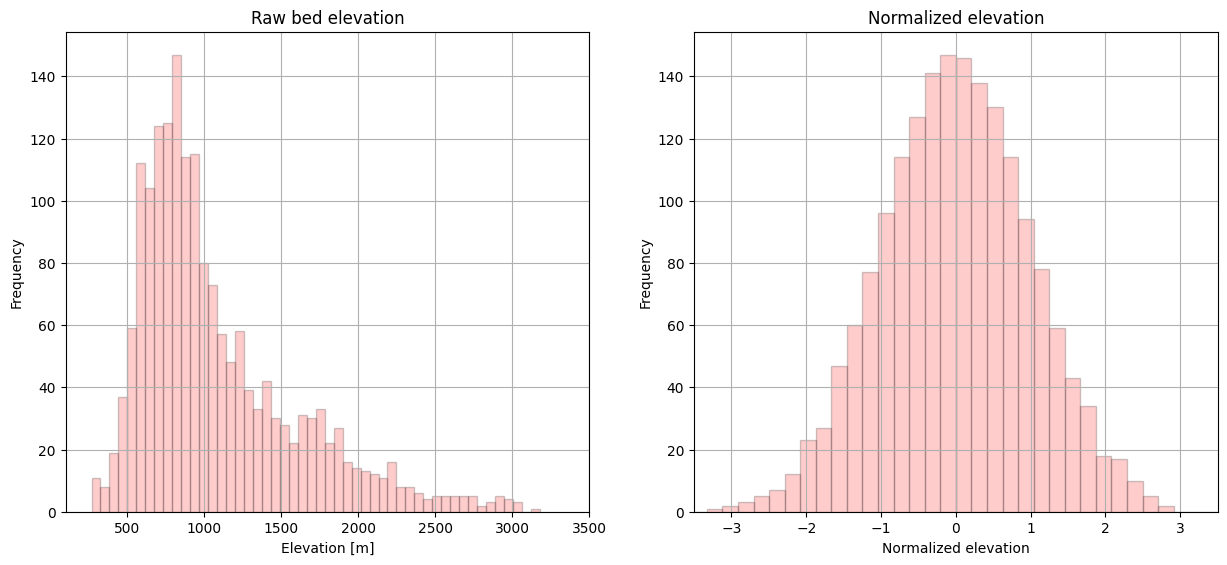

In [10]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_grid['Z'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([100,3500]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_grid['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

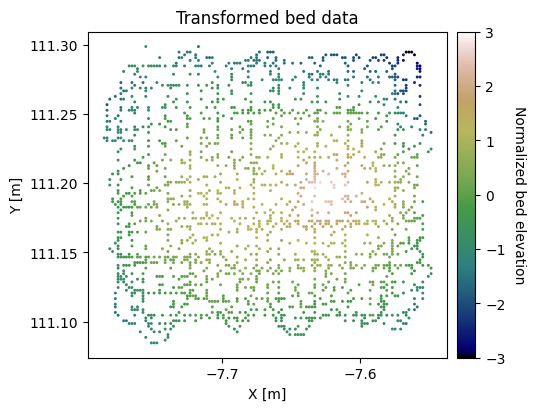

In [11]:
# plot transformed data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_grid['X'], df_grid['Y'], c=df_grid['Nbed'], vmin=-3, vmax=3, 
                     marker='.', s=5, cmap='gist_earth')
plt.title('Transformed bed data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-3, 3, 7), cax=cax)
cbar.set_label("Normalized bed elevation", rotation=270, labelpad=15)
plt.show()

## Compute Experimental Variogram

The semivariogram, often just referred to as the variogram, is used to qauntify spatial dependence for irregularly spaced data. It computes the average variance of the difference between two data points with a given separation distance, or lag distance $\bf{h}$.

$$
\gamma(h) = \frac{1}{2 N(h)} \sum^{N}_{\alpha=1} (Z(x_\alpha) - Z(x_\alpha + h))^2  
$$


where $x$ is a spatial location, $Z(x)$ is a variable (e.g. bed elevation), and $N$ is the number of lag distances. This can become computationally expensive, so we recommend randomly downsampling for large datasets.

We'll start by computing the isotropic variogram, which averages across different azimuthal directions using the Scikit GStat tools. 

c:\Users\sekar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_lsq\trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)


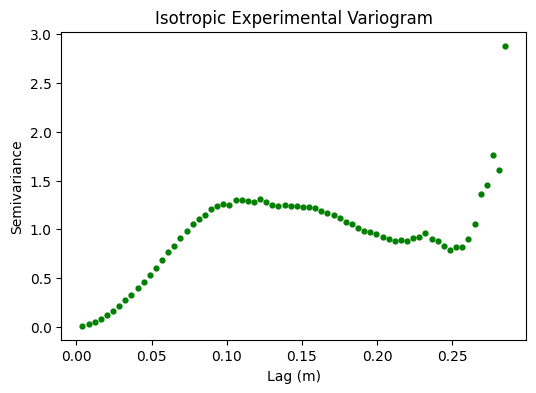

In [12]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000      # maximum range distance
n_lags = 70         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

This plot shows the expected variance between two points as a function of lag distance. So for a lag distance of approximately zero, the variogram is close to zero because two points in the same location should not have much variability. The curve should start leveling out at $\gamma(\bf{h}) = 1$ because our data has undergone a normal score transformation.

Glacial topography is often highly anisotropic. So let's try calculating the variogram for different azimuthal directions.

In [13]:
# directional variogram

V0 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=0, tolerance=15)

V45 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=45, tolerance=15)

V90 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                   maxlag = maxlag, normalize=False, azimuth=90, tolerance=15)

V135 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=135, tolerance=15)

x0 = V0.bins
y0 = V0.experimental

x45 = V45.bins
y45 = V45.experimental

x90 = V90.bins
y90 = V90.experimental

x135 = V135.bins
y135 = V135.experimental

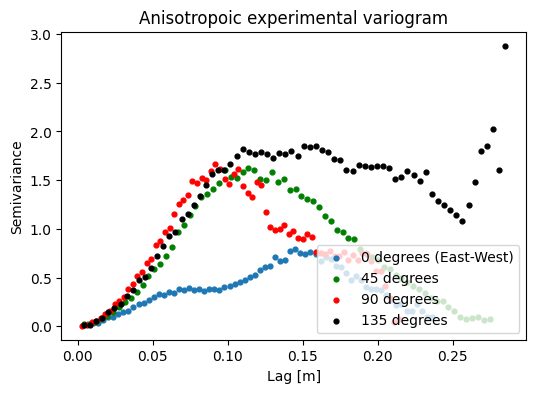

In [14]:
# plot multidirectional variogram
plt.figure(figsize=(6,4))
plt.scatter(x0, y0, s=12, label='0 degrees (East-West)')
plt.scatter(x45, y45,s=12, c='g', label='45 degrees')
plt.scatter(x90, y90, s=12, c='r', label='90 degrees')
plt.scatter(x135, y135, s=12, c='k', label='135 degrees')
plt.title('Anisotropoic experimental variogram')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='lower right')
plt.show()

This shows us how the spatial dependencies vary in different directions. We do not see significant anisotropy in this example at < 30 km lags.

We will also point out that the data gridding process can cause percieved smoothing in the 0 and 90 degree directions. So it could be useful to check the variogram for the non-gridded data to ensure that your interpretation is correct.


Download the {Download}`tutorial<./1_Experimental_Variogram.ipynb>`.